In [3]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [6]:
#READ IN THE DATA
filepath = "/Users/bram/dev/projects/Taxi-Challenge/"

taxi_rides = pd.read_csv(filepath + 'Challenge/new_york_taxi.csv')
taxi_zones = pd.read_csv(filepath + 'Challenge/taxi_zones.csv')

In [7]:
#General understanding of the data
taxi_rides.info()
taxi_rides.isna().sum()

#742k rides
#no na's, Hurray!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 742262 entries, 0 to 742261
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VendorID               742262 non-null  int64  
 1   tpep_pickup_datetime   742262 non-null  object 
 2   tpep_dropoff_datetime  742262 non-null  object 
 3   passenger_count        742262 non-null  int64  
 4   trip_distance          742262 non-null  float64
 5   RatecodeID             742262 non-null  int64  
 6   PULocationID           742262 non-null  int64  
 7   DOLocationID           742262 non-null  int64  
 8   payment_type           742262 non-null  int64  
 9   fare_amount            742262 non-null  float64
 10  extra                  742262 non-null  float64
 11  mta_tax                742262 non-null  float64
 12  tip_amount             742262 non-null  float64
 13  tolls_amount           742262 non-null  float64
 14  improvement_surcharge  742262 non-nu

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
dtype: int64

In [8]:
#Check if there are negative values
taxi_rides.min()

VendorID                             1
tpep_pickup_datetime     01-01-18 0:00
tpep_dropoff_datetime    01-01-18 0:00
passenger_count                      0
trip_distance                      0.0
RatecodeID                           1
PULocationID                         1
DOLocationID                         1
payment_type                         1
fare_amount                     -198.0
extra                             -4.5
mta_tax                           -0.5
tip_amount                        -1.0
tolls_amount                     -10.5
improvement_surcharge             -0.3
total_amount                    -209.3
dtype: object

In [9]:
#Taxi drivers erase trips (because of disputes etc.) by adding the a new trip with the negative cost
negative_trips = taxi_rides[(taxi_rides['fare_amount'] < 0)].index
initial_trips = negative_trips + 1
deleted_trips = initial_trips.append(negative_trips)
deleted_trips.sort_values()

#Drop negative values and 0's
taxi_rides.drop(deleted_trips , inplace=True)
len(deleted_trips)

Int64Index([    58,     59,    830,    831,   3834,   3835,   4054,   4055,
              4210,   4211,
            ...
            735662, 735663, 737058, 737059, 741430, 741431, 741568, 741569,
            741871, 741872],
           dtype='int64', length=820)

820

In [10]:
#select total amounts equal to 0
indexNames = taxi_rides[taxi_rides['total_amount'] == 0].index

 
#Drop 0's
taxi_rides.drop(indexNames , inplace=True)
len(indexNames)

#Change the only remaining negative value into 0
taxi_rides[taxi_rides['extra']==-0.4]
taxi_rides.at[41838,'extra'] = 0

114

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
41838,1,01-01-18 2:39,01-01-18 2:47,1,1.9,1,181,188,1,8.5,-0.4,0.5,0.0,0.0,0.3,8.9


In [11]:
#Table different payment types 
taxi_rides.payment_type.value_counts()

#Drop the 'No charge' and 'Dispute' payment types, this small amount of datapoints doesn't bring value to our analysis
indexNames = taxi_rides[(taxi_rides['payment_type'] == 3) | 
                        (taxi_rides['payment_type'] == 4)  
                        ].index
taxi_rides.drop(indexNames , inplace=True)
len(indexNames)

1    458761
2    277528
3      4005
4      1034
Name: payment_type, dtype: int64

5039

In [12]:
#Check if there's any weird passengers counts
taxi_rides['passenger_count'].unique()
taxi_rides.passenger_count.value_counts()


array([1, 2, 3, 5, 4, 6, 0, 7, 8, 9])

1    510302
2    114224
5     35265
3     33367
6     21365
4     17661
0      4095
7         7
9         2
8         1
Name: passenger_count, dtype: int64

In [13]:
#Alter the rides with zero passengers to one
taxi_rides.loc[taxi_rides['passenger_count']== 0, 'passenger_count'] = 1

In [14]:
#Delete rides that did not register a distance
indexNames = taxi_rides[(taxi_rides['trip_distance'] == 0)].index
taxi_rides.drop(indexNames , inplace=True)
len(indexNames)

4181

In [15]:
#Check the RatecodeID distribution
taxi_rides.RatecodeID.value_counts()
taxi_rides['RatecodeID'].unique()

1    708709
2     19874
3      1766
5      1339
4       419
6         1
Name: RatecodeID, dtype: int64

array([1, 2, 5, 4, 3, 6])

In [16]:
#Zones 264 and 265 are used for rides starting or ending out of the region or possibly when there's a 
#problem with the geo-tracking of the taxi. The rows starting or ending in these regions are deleted
#taxi_zones.iloc[263:265]
taxi_zones = taxi_zones.iloc[0:263]

In [17]:
#Merge rides with zones and boroughs
taxi_rides = taxi_rides.merge(taxi_zones, left_on='PULocationID', right_on='location_id', how='inner')
taxi_rides = taxi_rides.rename(columns={"borough":"PUborough","zone": "PUzone", "service_zone": "PUservice_zone"})
taxi_rides = taxi_rides.merge(taxi_zones, left_on='DOLocationID', right_on='location_id', how='inner')
taxi_rides = taxi_rides.rename(columns={"borough":"DOborough","zone": "DOzone", "service_zone": "DOservice_zone"})
taxi_rides.shape


(714838, 26)

In [18]:
# Converting string into datetime and generating Pickup_hour and Dropoff_hour column

taxi_rides['Pickup_dt'] = taxi_rides.tpep_pickup_datetime.apply(lambda x:dt.strptime(x,"%d-%m-%y %H:%M"))
taxi_rides['Pickup_hour'] = taxi_rides.Pickup_dt.apply(lambda x:x.hour)
taxi_rides['Pickup_day'] = taxi_rides.Pickup_dt.apply(lambda x:x.day)


taxi_rides['Dropoff_dt'] = taxi_rides.tpep_dropoff_datetime.apply(lambda x:dt.strptime(x,"%d-%m-%y %H:%M"))
taxi_rides['Dropoff_hour'] = taxi_rides.Dropoff_dt.apply(lambda x:x.hour)
taxi_rides['Dropoff_day'] = taxi_rides.Dropoff_dt.apply(lambda x:x.day)

In [19]:
#Engineering new variables  

#Income (the amount that goes into the taxi driver's pocket)
taxi_rides['income'] = taxi_rides['fare_amount'] + taxi_rides['extra'] + taxi_rides['tip_amount']

# Get the difference between datetimes (in seconds)
taxi_rides['trip_time'] = taxi_rides['Dropoff_dt'] - taxi_rides['Pickup_dt']
taxi_rides['trip_time'] = taxi_rides['trip_time'] / np.timedelta64(1, 'h')

#Mean driving speed (in mph)
taxi_rides['speed'] = taxi_rides['trip_distance'] / (taxi_rides['trip_time'])

#tip rate (%/100 of total bill)
taxi_rides['tip_rate'] = taxi_rides['tip_amount'] / (taxi_rides['fare_amount'] + taxi_rides['extra'] + taxi_rides['mta_tax'] + taxi_rides['improvement_surcharge'] + taxi_rides['tolls_amount'])

#trips to or from JFK or LaGuardia airport.
taxi_rides.loc[(taxi_rides['PUzone'] == 'JFK Airport')|(taxi_rides['PUzone'] == 'LaGuardia Airport'),'airport'] = 'from'
taxi_rides.loc[(taxi_rides['DOzone'] == 'JFK Airport')|(taxi_rides['DOzone'] == 'LaGuardia Airport'),'airport'] = 'towards'
taxi_rides['airport'] = taxi_rides['airport'].fillna('none')

#dummy for trips between noon and midnight
taxi_rides.loc[taxi_rides['Pickup_hour']>11,'pm'] = 1
taxi_rides.loc[taxi_rides['Pickup_hour']<=11,'pm'] = 0

#dummy for trips on new year's day
taxi_rides.loc[taxi_rides['Pickup_day'] == 1,'new_year'] = 1
taxi_rides.loc[taxi_rides['Pickup_day'] != 1,'new_year'] = 0

In [20]:
#Remove rides with an infinite or unrealistical speed (trip_time is zero or close)
x= taxi_rides[taxi_rides['speed']>100]
x[['Pickup_dt','Dropoff_dt','trip_time','income','trip_distance','speed']].head()
#Drop the rides with speed above 100 mph
indexNames = taxi_rides[(taxi_rides['speed'] > 100)].index
taxi_rides.drop(indexNames , inplace=True)
len(indexNames)

,Pickup_dt,Dropoff_dt,trip_time,income,trip_distance,speed
6287,2018-01-01 06:58:00,2018-01-01 06:58:00,0.0,3.5,0.41,inf
6296,2018-01-01 09:31:00,2018-01-01 09:31:00,0.0,3.5,0.40,inf
7057,2018-01-01 09:20:00,2018-01-01 09:20:00,0.0,3.0,0.10,inf
7061,2018-01-01 11:03:00,2018-01-01 11:03:00,0.0,2.5,0.07,inf
7107,2018-01-01 20:38:00,2018-01-01 20:38:00,0.0,3.0,3.20,inf


1075

In [21]:
#Delete all rides with negative durations or zero
taxi_rides['trip_time'].describe()
indexNames = taxi_rides[taxi_rides['trip_time']<0].index
taxi_rides.drop(indexNames , inplace=True)
len(indexNames)

count    713763.000000
mean          0.260978
std           1.117748
min         -95.200000
25%           0.100000
50%           0.166667
75%           0.266667
max          24.000000
Name: trip_time, dtype: float64

1

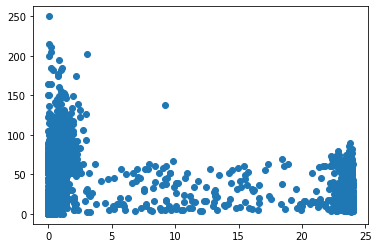

Text(0, 0.5, 'Trip distance')

Text(0.5, 0, 'Trip time')

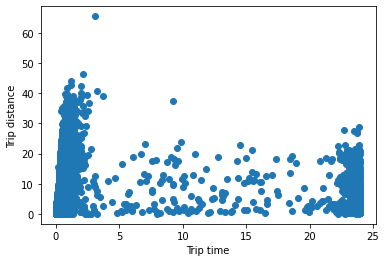

In [22]:
#Long durations seem to be clustered around 23-24 hours and they don't tend to have a large distance or bill.
#Something's wrong
plt.scatter(taxi_rides['trip_time'], taxi_rides['income'])
plt.show()
plt.scatter(taxi_rides['trip_time'], taxi_rides['trip_distance'])
plt.ylabel('Trip distance')
plt.xlabel('Trip time')
plt.show()

trip_time_bucket
(0.0, 1.0]      709238
(1.0, 2.0]        2795
(2.0, 3.0]          42
(3.0, 4.0]          11
(4.0, 5.0]           4
(5.0, 6.0]          10
(6.0, 7.0]           7
(7.0, 8.0]          12
(8.0, 9.0]           9
(9.0, 10.0]         15
(10.0, 11.0]        11
(11.0, 12.0]         8
(12.0, 13.0]         6
(13.0, 14.0]        10
(14.0, 15.0]         8
(15.0, 16.0]        10
(16.0, 17.0]         8
(17.0, 18.0]         4
(18.0, 19.0]         6
(19.0, 20.0]         6
(20.0, 21.0]         7
(21.0, 22.0]        11
(22.0, 23.0]        69
(23.0, 24.0]      1455
dtype: int64

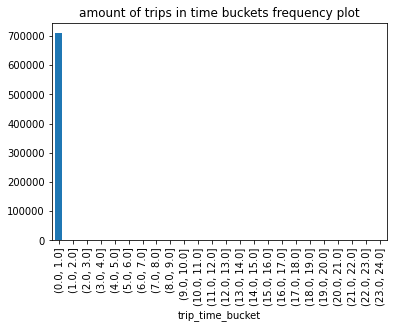

In [23]:
#Bucket per hour
bucket_array = np.linspace(0, 24, 25)
taxi_rides['trip_time_bucket'] = pd.cut(taxi_rides['trip_time'], bucket_array)
a = taxi_rides.groupby('trip_time_bucket').size()
a
plt = a.plot(kind='bar',title='amount of trips in time buckets frequency plot')

In [24]:
#I assume that there must be something wrong with long trips lacking an increased distance or bill.
#Therefore I delete all trips taking more than 3 hours
indexNames = taxi_rides[taxi_rides['trip_time']>3].index
taxi_rides.drop(indexNames , inplace=True)
len(indexNames)

1687

In [25]:
#Check if there are negative values
taxi_rides.min()

VendorID                                       1
tpep_pickup_datetime               01-01-18 0:00
tpep_dropoff_datetime              01-01-18 0:01
passenger_count                                1
trip_distance                               0.01
RatecodeID                                     1
PULocationID                                   1
DOLocationID                                   1
payment_type                                   1
fare_amount                                  0.0
extra                                        0.0
mta_tax                                      0.0
tip_amount                                   0.0
tolls_amount                                 0.0
improvement_surcharge                        0.0
total_amount                                 0.3
location_id_x                                  1
PUborough                                  Bronx
PUzone                   Allerton/Pelham Gardens
PUservice_zone                          Airports
ntacode_x           

In [26]:
#Drop the columns that don't seem interesting for the analysis
taxi_rides = taxi_rides.drop(['tpep_pickup_datetime','tpep_dropoff_datetime',
                 'location_id_x','location_id_y','ntacode_x','ntacode_y','Dropoff_dt','Pickup_dt','fare_amount',
                              'extra','mta_tax','tolls_amount','improvement_surcharge'], axis=1)

In [27]:
taxi_rides.head()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,tip_amount,total_amount,PUborough,...,Dropoff_hour,Dropoff_day,income,trip_time,speed,tip_rate,airport,pm,new_year,trip_time_bucket
0,1,1,0.50,1,41,24,2,0.00,5.80,Manhattan,...,0,1,5.00,0.050000,10.00,0.000000,none,0.0,1.0,"(0.0, 1.0]"
1,2,1,0.91,1,41,24,1,1.00,7.80,Manhattan,...,0,1,7.00,0.083333,10.92,0.147059,none,0.0,1.0,"(0.0, 1.0]"
2,1,1,0.70,1,41,24,2,0.00,6.30,Manhattan,...,1,1,5.50,0.083333,8.40,0.000000,none,0.0,1.0,"(0.0, 1.0]"
3,2,1,0.97,1,41,24,2,0.00,7.30,Manhattan,...,1,1,6.50,0.100000,9.70,0.000000,none,0.0,1.0,"(0.0, 1.0]"
4,2,3,0.97,1,41,24,1,2.19,9.49,Manhattan,...,1,1,8.69,0.083333,11.64,0.300000,none,0.0,1.0,"(0.0, 1.0]"


In [28]:
taxi_rides.to_csv(filepath + 'cleaned_taxi_rides.csv')